In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt

In [ ]:
def construir_generador():
    modelo = models.Sequential()
    modelo.add(Input(shape=(100,)))
    modelo.add(layers.Dense(128, activation='relu'))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU(negative_slope=0.2))
    modelo.add(layers.Dense(784, activation='tanh'))
    modelo.add(layers.Reshape((28, 28, 1)))
    return modelo

def construir_discriminador():
    modelo = models.Sequential()
    modelo.add(Input(shape=(28, 28, 1)))
    modelo.add(layers.Flatten())
    modelo.add(layers.Dense(128, activation='relu'))
    modelo.add(layers.LeakyReLU(negative_slope=0.2))
    modelo.add(layers.Dense(1, activation='sigmoid'))
    return modelo

def construir_gan(generador, discriminador):
    discriminador.trainable = False
    entrada_gan = Input(shape=(100,))
    imagen_generada = generador(entrada_gan)
    salida_gan = discriminador(imagen_generada)
    gan = models.Model(entrada_gan, salida_gan)
    return gan

In [ ]:
def entrenar_gan(epochs=500, batch_size=64, intervalo_muestra=100):
    (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=-1)

    dim_ruido = 100

    discriminador = construir_discriminador()
    discriminador.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
    generador = construir_generador()

    gan = construir_gan(generador, discriminador)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

    etiquetas_reales = np.ones((batch_size, 1))
    etiquetas_falsas = np.zeros((batch_size, 1))

    for epoca in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imagenes_reales = X_train[idx]
        ruido = np.random.normal(0, 1, (batch_size, dim_ruido))
        imagenes_generadas = generador(ruido, training=True)
        discriminador.trainable = True
        perdida_d_real = discriminador.train_on_batch(imagenes_reales, etiquetas_reales)
        perdida_d_falsa = discriminador.train_on_batch(imagenes_generadas, etiquetas_falsas)
        perdida_d = 0.5 * np.add(perdida_d_real, perdida_d_falsa)
        discriminador.trainable = False

        del imagenes_reales, imagenes_generadas
        tf.keras.backend.clear_session()

        ruido = np.random.normal(0, 1, (batch_size, dim_ruido))
        perdida_g = gan.train_on_batch(ruido, etiquetas_reales)

        if epoca % intervalo_muestra == 0:
            print(f"Época {epoca}, Pérdida del Discriminador: {perdida_d[0]}, Pérdida del Generador: {perdida_g}")
            mostrar_imagenes(generador)

Epoch 0, Discriminator Loss: 1.198039174079895, Generator Loss: [array(1.0401907, dtype=float32), array(1.0401907, dtype=float32), array(0.2421875, dtype=float32)]


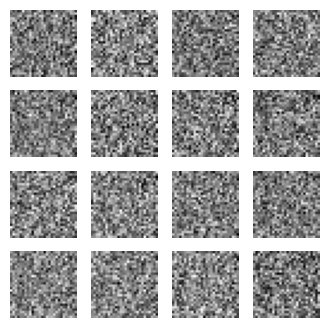

Epoch 100, Discriminator Loss: 0.39915573596954346, Generator Loss: [array(0.39964446, dtype=float32), array(0.39964446, dtype=float32), array(0.7248608, dtype=float32)]


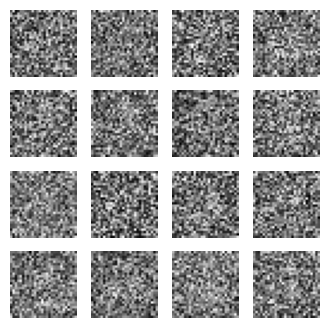

Epoch 200, Discriminator Loss: 0.36624574661254883, Generator Loss: [array(0.3665249, dtype=float32), array(0.3665249, dtype=float32), array(0.8002954, dtype=float32)]


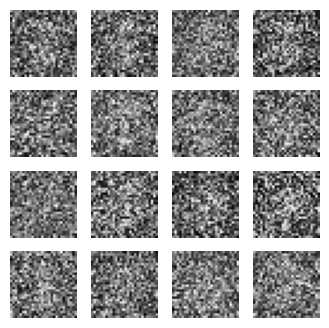

Epoch 300, Discriminator Loss: 0.37202417850494385, Generator Loss: [array(0.37229562, dtype=float32), array(0.37229562, dtype=float32), array(0.81018996, dtype=float32)]


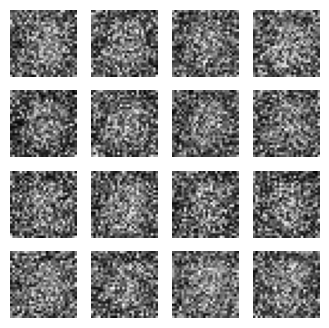

Epoch 400, Discriminator Loss: 0.39273273944854736, Generator Loss: [array(0.39294198, dtype=float32), array(0.39294198, dtype=float32), array(0.8004208, dtype=float32)]


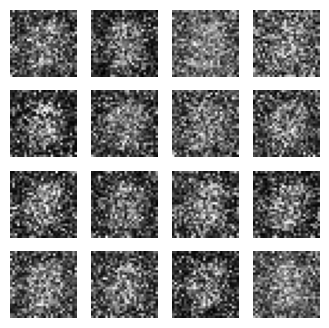

In [ ]:
def mostrar_imagenes(generador, filas_grid=4, columnas_grid=4):
    ruido = np.random.normal(0, 1, (filas_grid * columnas_grid, 100))
    imagenes_generadas = generador(ruido, training=False)
    imagenes_generadas = 0.5 * imagenes_generadas + 0.5

    fig, axs = plt.subplots(filas_grid, columnas_grid, figsize=(4, 4))
    contador = 0
    for i in range(filas_grid):
        for j in range(columnas_grid):
            axs[i, j].imshow(imagenes_generadas[contador, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            contador += 1
    plt.show()

entrenar_gan()
